In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import math as mp
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
from time import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
labels = pd.read_csv(r'labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


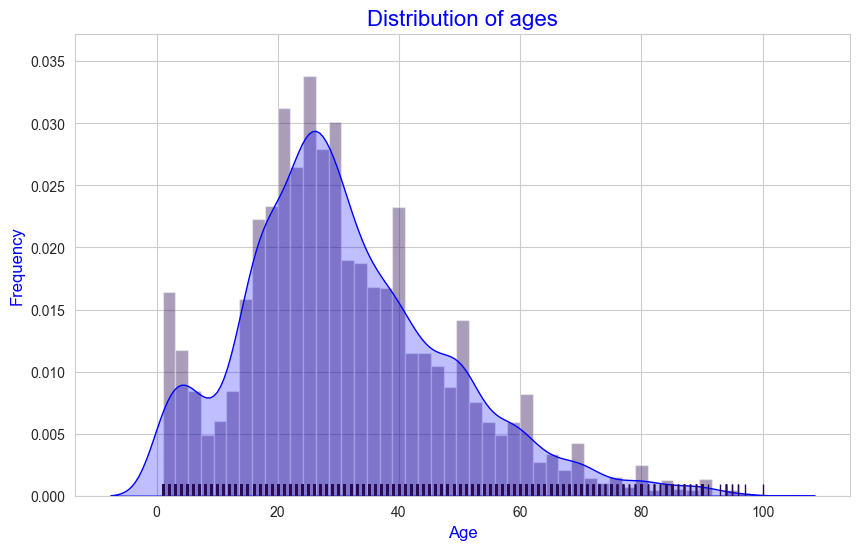

In [32]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'b'})
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of ages', fontsize=16, color='b')
plt.show()

In [3]:
# create datagenerator object for training and validation datasets
#rescale images using 1/255
train_datagen = ImageDataGenerator(
            #we will do normalization for image pixel values as following
            rescale=1 / 255
            )

In [4]:
#use flow_from_dataframe method to load images from directory and labels from dataframe
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory=r'final_files/final_files',
    x_col="file_name", 
    y_col="real_age",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",

    #to convert all images to same pixel size, for neural networks, all images should have similar size
        target_size=(224,224),

    #we will load images batch by batch (every time 32 images will be loaded)
    batch_size=32,
    seed=12345,
    )

Found 7591 validated image filenames.


In [5]:
#get one batch from our datagenerator and display images in it
features, target = next(train_datagen_flow)

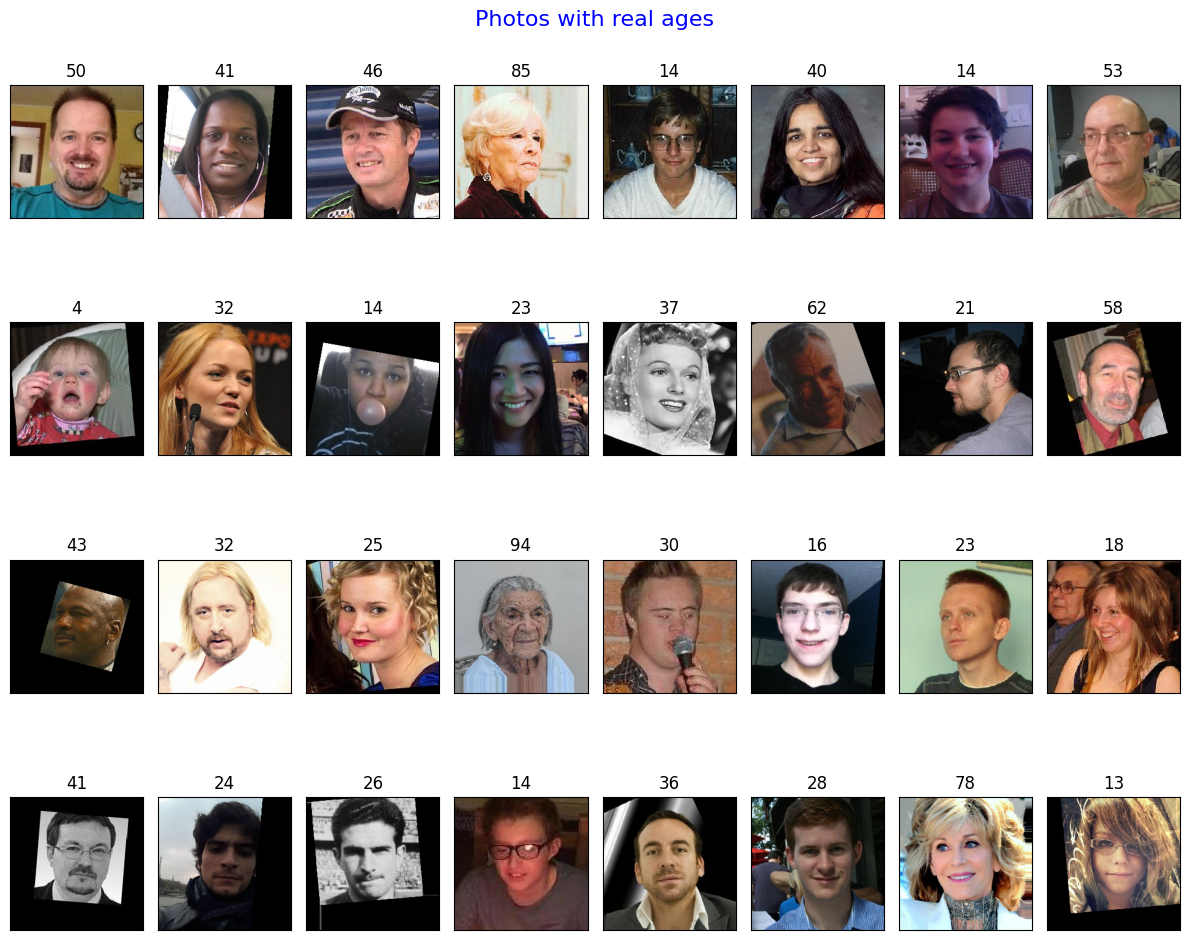

In [6]:
# display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with real ages',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

In [7]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

    return train_gen_flow



def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe = labels,
    directory=path +'final_files/final_files/',
    x_col="file_name",
    y_col="real_age", 
    class_mode="raw", 
    target_size=(224,224), 
    batch_size=32,
    subset = "validation",
    seed=12345,
    )
    
    return test_gen_flow

def create_model(input_shape):
    
    """
    It defines the model
    """
    # we will use ResNet50 architecture, with freezing top layers
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    
    #now we will add our custom layers
    #without drop layer, neural networks can easily overfit
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
     #final layer, since we are doing regression we will add only one neuron (unit)
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    print(model.summary())

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)

    return model

In [8]:
path="/"  # Assign path according to your need

#load training and testing (actually this is validation data set)
train_data = load_train(path)
test_data = load_test(path)

#build a model
model = create_model(input_shape = (224, 224, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None


In [9]:
model = train_model(model, train_data, test_data)   # It took 3 hrs to train the model, as there are many images in training dataset. So, please run it on GPU systems to train it, faster.

Epoch 1/20
178/178 - 579s - loss: 12.3920 - mae: 12.3920 - val_loss: 13.6953 - val_mae: 13.6953 - 579s/epoch - 3s/step
Epoch 2/20
178/178 - 593s - loss: 10.5336 - mae: 10.5336 - val_loss: 18.5465 - val_mae: 18.5465 - 593s/epoch - 3s/step
Epoch 3/20
178/178 - 599s - loss: 9.5238 - mae: 9.5238 - val_loss: 14.1376 - val_mae: 14.1376 - 599s/epoch - 3s/step
Epoch 4/20
178/178 - 598s - loss: 8.7617 - mae: 8.7617 - val_loss: 12.0902 - val_mae: 12.0902 - 598s/epoch - 3s/step
Epoch 5/20
178/178 - 602s - loss: 8.3330 - mae: 8.3330 - val_loss: 14.4865 - val_mae: 14.4865 - 602s/epoch - 3s/step
Epoch 6/20
178/178 - 601s - loss: 7.6489 - mae: 7.6489 - val_loss: 10.6443 - val_mae: 10.6443 - 601s/epoch - 3s/step
Epoch 7/20
178/178 - 599s - loss: 7.2209 - mae: 7.2209 - val_loss: 9.3572 - val_mae: 9.3572 - 599s/epoch - 3s/step
Epoch 8/20
178/178 - 596s - loss: 6.7540 - mae: 6.7540 - val_loss: 11.1031 - val_mae: 11.1031 - 596s/epoch - 3s/step
Epoch 9/20
178/178 - 598s - loss: 6.2901 - mae: 6.2901 - val_l

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [11]:
# h5 file store huge amounts of numerical data, and easily manipulate that data from NumPy.

model.save('modelv1.h5')  # This model is saved into modelv1.h5, So it allows us to not train the model again and stored it in the same directory (time saving process).

In [46]:

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


prototxt="caffemodel/deploy.prototxt"
caffeModel="caffemodel/res10_300x300_ssd_iter_140000.caffemodel"
opencv_dnn_model = cv2.dnn.readNetFromCaffe(prototxt, caffeModel)


# The below function allows you to detect the face and draw a box around it using CNN.
def cvDnnDetectFaces(image, opencv_dnn_model, age, min_confidence=0.5,display=True):

    image_height, image_width, _ = image.shape

    output_image = image.copy()

    preprocessed_image = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                                               mean=(104.0, 117.0, 123.0), swapRB=False, crop=False)

    opencv_dnn_model.setInput(preprocessed_image)

    start = time()

    results = opencv_dnn_model.forward()

    end = time()

    for face in results[0][0]:

        face_confidence = face[2]

        if face_confidence > min_confidence:

            bbox = face[3:]

            x1 = int(bbox[0] * image_width)
            y1 = int(bbox[1] * image_height)
            x2 = int(bbox[2] * image_width)
            y2 = int(bbox[3] * image_height)
            age=int(mp.ceil(age))
            # Format the confidence score to display the first two decimal places
            confidence_str = "Predicted Age : "+str(age)

            # Draw the rectangle around the face
            cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x2, y2), color=(255, 255, 0), thickness=image_width // 200)

            # Add the formatted confidence score above the face
            text = f'{confidence_str}'
            cv2.putText(output_image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

    if display:
        plt.figure(figsize=[10, 10])
        plt.subplot(121)
        plt.imshow(output_image[:, :, ::-1])
        plt.title("Input")
        plt.axis('off')
        plt.show()
    else:
        return output_image, results




In [19]:
#005806.jpg Old 

In [42]:

model = load_model("modelv1.h5")

# image path
img_path = 'TestFolder/007429.jpg' 

# load a single image
new_image = load_image(img_path)

# check prediction
pred = model.predict(new_image)

1/1 [==============================] - 1s 730ms/step


In [50]:
def predict(path):  # To predict the age of a person in an image.
    model = load_model("modelv1.h5")
    img_path = path
    new_image = load_image(img_path)
    pred = model.predict(new_image)
    image = cv2.imread(path)
    cvDnnDetectFaces(image, opencv_dnn_model,pred[0][0],min_confidence=0.5 ,display=True)
    print("Predicted Age: ",int(mp.ceil(pred[0][0])))

## Final Output

1/1 [==============================] - 1s 726ms/step


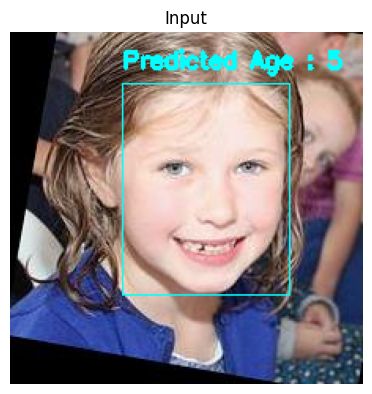

Predicted Age:  5


In [72]:
predict("TestFolder/007429.jpg")

1/1 [==============================] - 1s 718ms/step


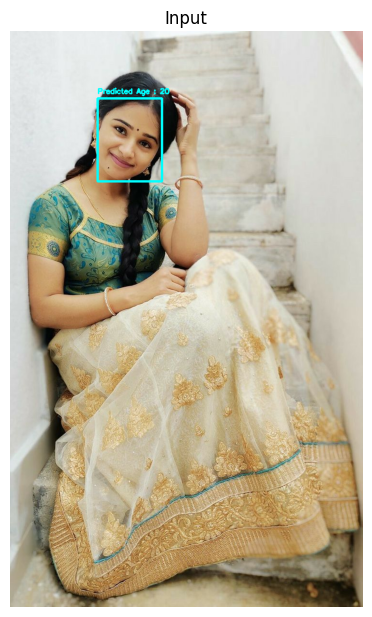

Predicted Age:  20


In [71]:
predict("TestFolder/girl1.png")

1/1 [==============================] - 1s 730ms/step


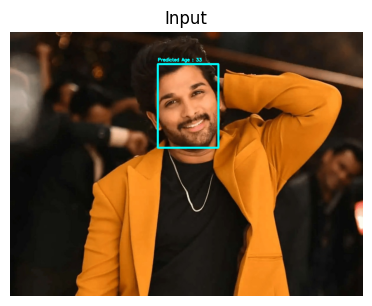

Predicted Age:  33


In [70]:
predict("TestFolder/arjun.png")

1/1 [==============================] - 1s 752ms/step


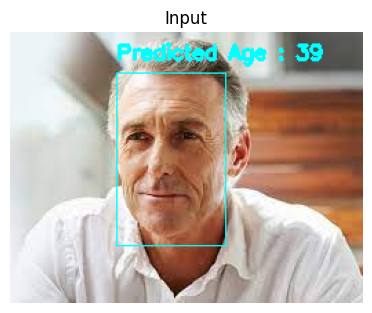

Predicted Age:  39


In [69]:
predict("TestFolder/guy4.jpeg")

1/1 [==============================] - 1s 720ms/step


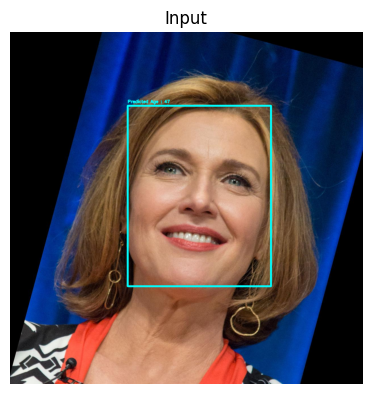

Predicted Age:  47


In [68]:
predict("TestFolder/005620.jpg")

1/1 [==============================] - 1s 736ms/step


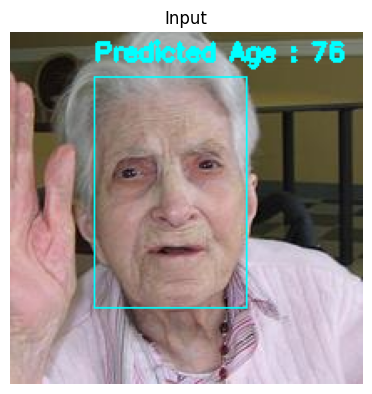

Predicted Age:  76


In [67]:
predict("TestFolder/005806.jpg")